In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import h5py
from pathlib import Path
from tqdm.auto import tqdm, trange
import csv

In [32]:
from reglib import lfpreg, ap_filter

In [33]:
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Paths and metadata

In [34]:
data_home = Path("E:/DataForNatProtocol/Pt02/").expanduser()
pt_dir = data_home
print(pt_dir)

E:\DataForNatProtocol\Pt02


In [35]:
raw_dir = pt_dir
raw_lfp_bin = next(raw_dir.glob("AllinBrain*lf.bin"))
raw_lfp_bin

WindowsPath('E:/DataForNatProtocol/Pt02/AllinBrain_Pt02.imec0.lf.bin')

In [36]:
ppx_dir = Path(pt_dir).expanduser() / 'ppxaautob'
ppx_dir.mkdir(exist_ok=True)
ppx_lfp_bin = ppx_dir / raw_lfp_bin.name
ppx_lfp_bin



WindowsPath('E:/DataForNatProtocol/Pt02/ppxaautob/AllinBrain_Pt02.imec0.lf.bin')

In [37]:
# load geometry array in the usual n_channels x 2 format
#geom = loadmat(str("E:/Chang_data/NP03_B02_g0_t0/NP03_B02_ChannelMap.mat"))
#geom = np.c_[geom["xcoords"], geom["ycoords"]]
#geom.shape

channel_path = next(raw_dir.glob("AllinBrain*_ChannelMap.mat"))
print(channel_path)

import h5py
with h5py.File(channel_path) as h5:
    geom = np.c_[h5["xcoords"][:], h5["ycoords"][:]]
    timeStart = int(np.c_[h5["TimeRange1"][:]])
    timeEnd = int(np.c_[h5["TimeRange2"][:]])
    Channels = int(np.c_[h5["NumberOfChannels"][:]])
    
print(geom.shape)
#geom
print(Channels)
print(timeStart)
print(timeEnd)
#print(geom)



E:\DataForNatProtocol\Pt02\AllinBrain_Pt02_ChannelMap.mat
(384, 2)
384
220
865


(-0.5, 24999.5, 382.5, -0.5)

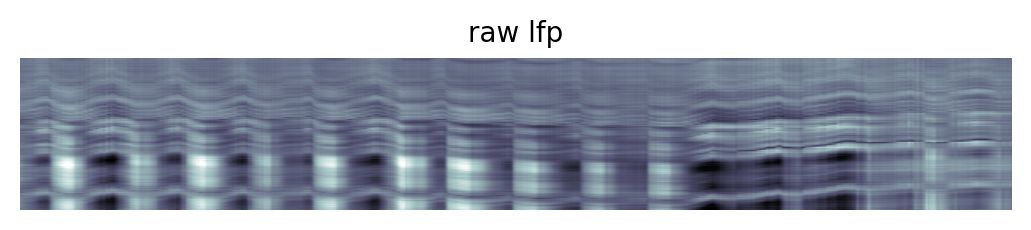

In [38]:
# plot original
lfp0 = np.memmap(raw_lfp_bin, dtype=np.int16).reshape(-1, Channels)[:, :-1]
plt.imshow(lfp0[250*2500:250*2500 + 10 * 2500].T, aspect=10, cmap=plt.cm.bone);
plt.title("raw lfp")
plt.axis("off")


## Preprocessing

In [39]:
int(np.floor((timeEnd-timeStart) * 2500))

1612500

In [40]:
# this preprocessing runs a destriping routine from ibl-neuropixel,
# which is essentially standardization + CMR, resamples to 250Hz,
# and averages channels at the same depth.
# we also add a BP filter at the beginning since the hardware filter
# has a kind of slow roll off and some spikes get through.
# alternatively, you could set avg_depth=False and csd=True to compute
# the csd (which is done columnwise and then averaged across depth, 
# which is smarter.). need to delete the ppx file and folder (step 7) to re-run this as it will throw an error
ap_filter.run_preprocessing(
    raw_lfp_bin,
    ppx_lfp_bin,
    geom=geom,
    n_channels=Channels,
    fs=2500,
    bp=(0.5, 250),
    extra_channels=0,
    resample_to=250,
    lfp_destripe=False,
    avg_depth=False,
    csd=True,
    t_start=timeStart,
    t_end=timeEnd,
);

T_samples 2183292 T_seconds 873.3168


filter:   0%|          | 0/129 [00:00<?, ?it/s]

## Test registration of a small chunk to pick parameters

In [41]:
y_unique = np.unique(geom[:, 1])

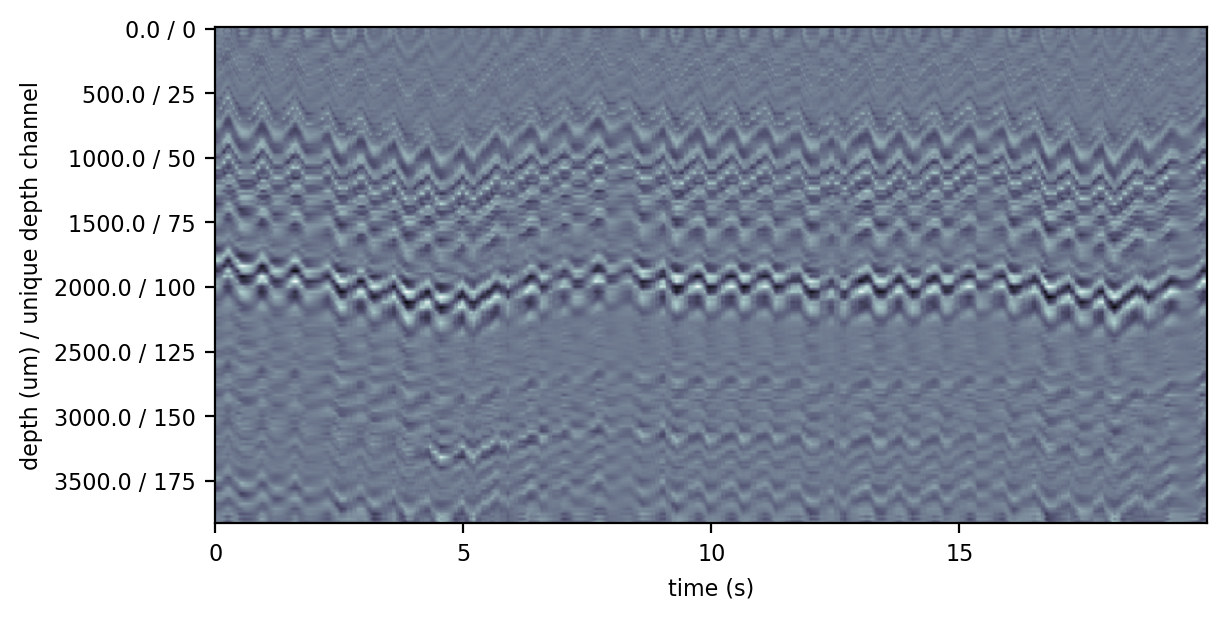

In [42]:
lfp = np.memmap(ppx_lfp_bin, dtype=np.float32).reshape(-1, y_unique.size)

# load 20 seconds starting at 250s
chunk = lfp[100 * 250 : 120 * 250]

# vis to check preprocessing went alright
fig, ax = plt.subplots()
ax.imshow(chunk.T, aspect=0.5 * np.divide(*chunk.shape), cmap=plt.cm.bone)
ax.set_yticks(
    np.arange(0, y_unique.size, 25),
    [f"{u} / {i}" for i, u in zip(np.arange(0, y_unique.size, 25), y_unique[np.arange(0, y_unique.size, 25)])],
)
ax.set_xticks(np.arange(0, 20 * 250, 5*250), np.arange(0, 20, 5))
ax.set_ylabel("depth (um) / unique depth channel")
ax.set_xlabel("time (s)");

In [43]:
# compute pairwise displacement and correlation matrices and visualize
# from above, we can see that the max displacement is <50 channels
D, C = lfpreg.calc_corr_decent(chunk.T, disp=50)

  0%|          | 0/157 [00:00<?, ?it/s]

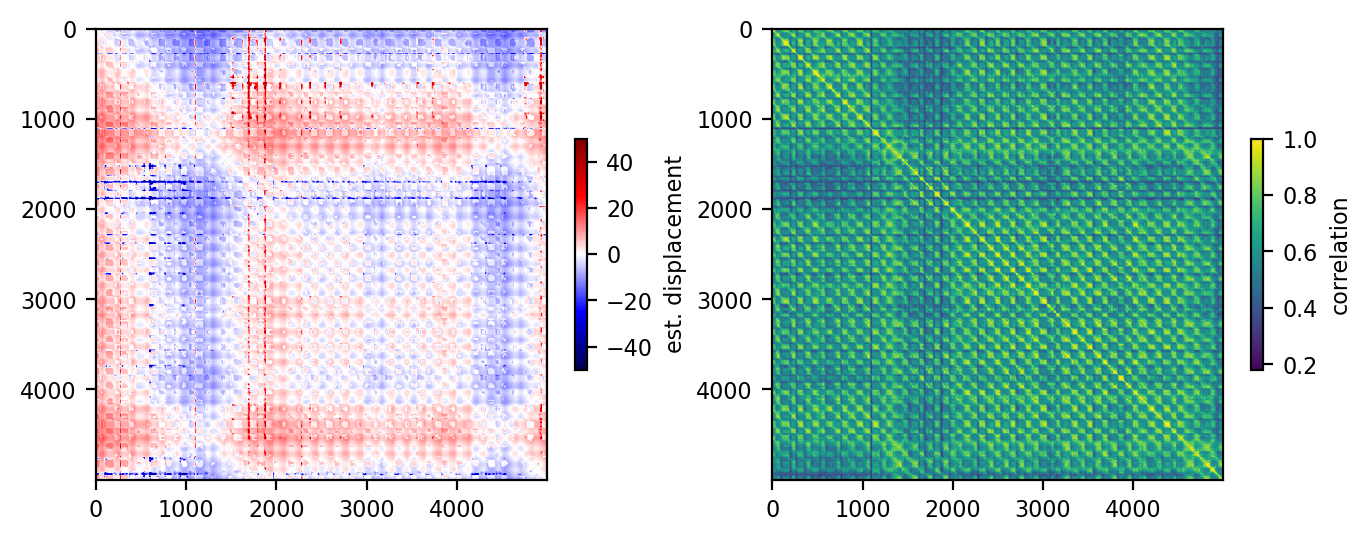

In [44]:
fig, (aa, ab) = plt.subplots(ncols=2, figsize=(8, 5))
ima = aa.imshow(D, vmin=-50, vmax=50, cmap=plt.cm.seismic)
plt.colorbar(ima, ax=aa, shrink=0.3, label="est. displacement")
imb = ab.imshow(C, cmap=plt.cm.viridis)
plt.colorbar(imb, ax=ab, shrink=0.3, label="correlation");

Test mincorr...:   0%|          | 0/4 [00:00<?, ?it/s]

48.0

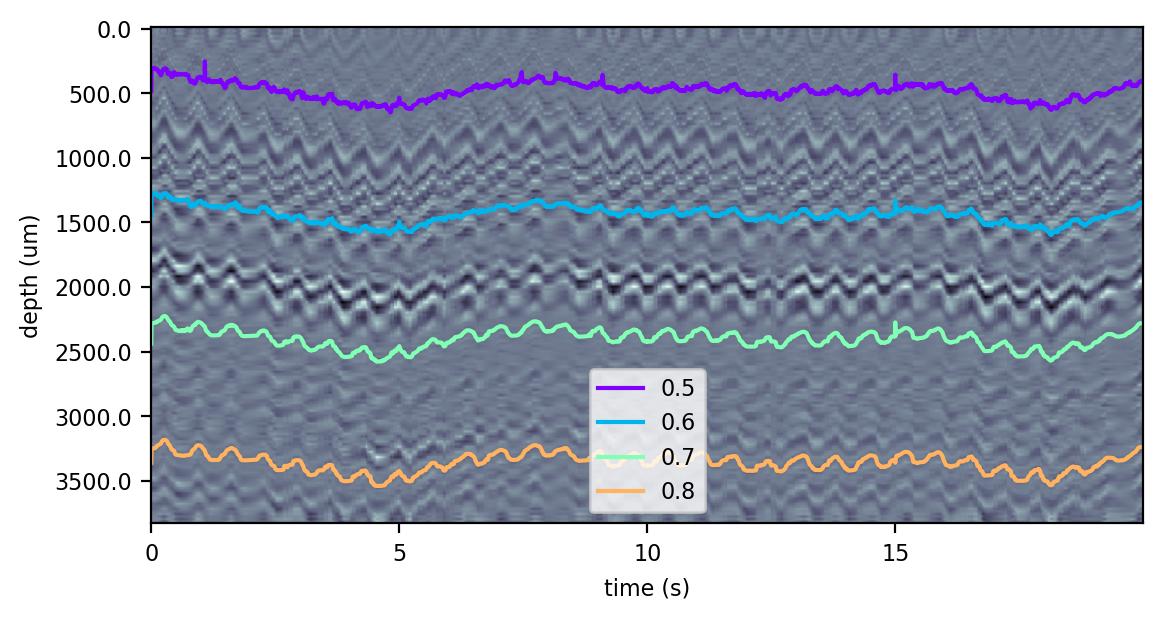

In [45]:
fig, ax = plt.subplots()
ax.imshow(chunk.T, aspect=0.5 * np.divide(*chunk.shape), cmap=plt.cm.bone)
ax.set_yticks(np.arange(0, y_unique.size, 25), y_unique[np.arange(0, y_unique.size, 25)])
ax.set_xticks(np.arange(0, 20 * 250, 5*250), np.arange(0, 20, 5))
ax.set_ylabel("depth (um)")
ax.set_xlabel("time (s)")

test_mincorrs = [0.5, 0.6, 0.7, 0.8]
for i in trange(len(test_mincorrs), desc="Test mincorr..."):
    mincorr = test_mincorrs[i]
    color = plt.cm.rainbow(i / len(test_mincorrs))
    p = lfpreg.psolvecorr(D, C, mincorr=mincorr, robust_iter=0)
    offset = y_unique.size / len(test_mincorrs)
    ax.plot(i * offset + offset / 2 + p, label=mincorr, color=color)
ax.legend();

offset

Test mincorr...:   0%|          | 0/4 [00:00<?, ?it/s]

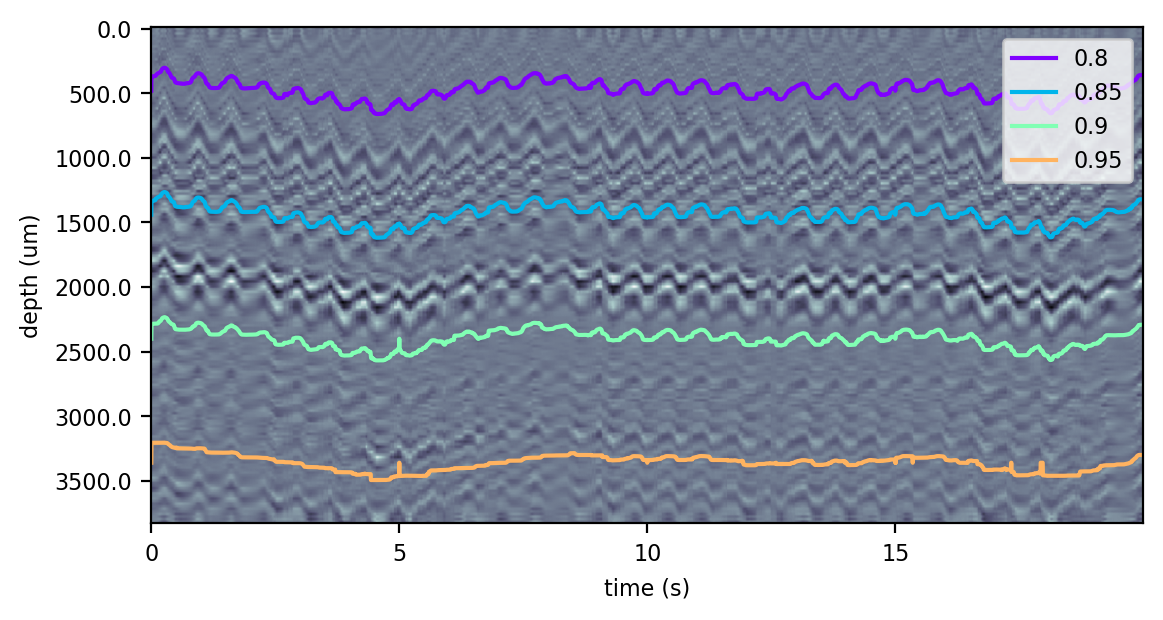

In [46]:
fig, ax = plt.subplots()
ax.imshow(chunk.T, aspect=0.5 * np.divide(*chunk.shape), cmap=plt.cm.bone)
ax.set_yticks(np.arange(0, y_unique.size, 25), y_unique[np.arange(0, y_unique.size, 25)])
ax.set_xticks(np.arange(0, 20 * 250, 5*250), np.arange(0, 20, 5))
ax.set_ylabel("depth (um)")
ax.set_xlabel("time (s)")

# change this around to look at the different types of tracking

test_mincorrs = [0.8,0.85, 0.9, 0.95]
for i in trange(len(test_mincorrs), desc="Test mincorr..."):
    mincorr = test_mincorrs[i]
    color = plt.cm.rainbow(i / len(test_mincorrs))
    p = lfpreg.psolvecorr(D, C, mincorr=mincorr, robust_iter=0)
    offset = y_unique.size / len(test_mincorrs)
    ax.plot(i * offset + offset / 2 + p, label=mincorr, color=color)
ax.legend();

It looks like `mincorr=0.8` is a fine choice.

## Use online method to register the full dataset

In [47]:
# recall that `lfp` is the full recording in a memmap (not in memory)
# this took about ~15mins on my laptop (no GPU) but is much faster on GPU
p = lfpreg.online_register_rigid(
    lfp.T,
    mincorr=0.8,
    disp=50,
    prior_lambda=1,
    adaptive_mincorr_percentile=None,
)

  0%|          | 0/313 [00:00<?, ?it/s]

batches:   0%|          | 0/16 [00:00<?, ?it/s]

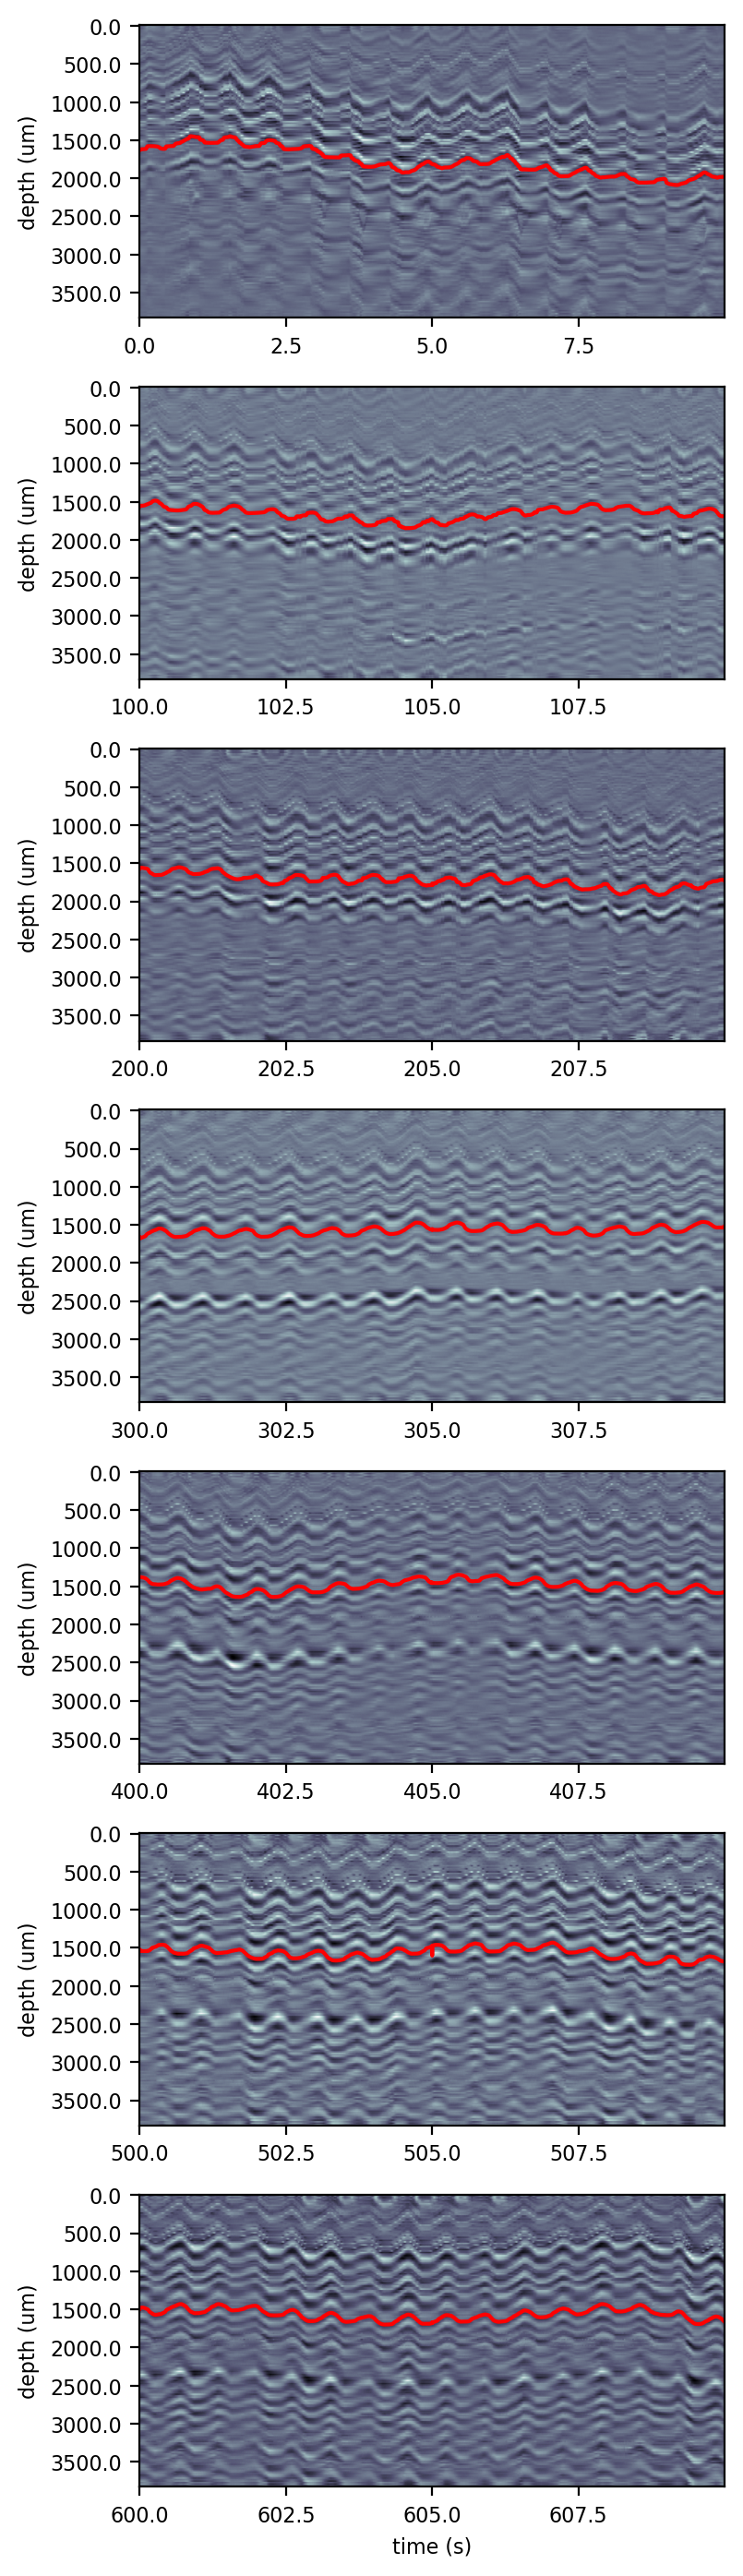

In [48]:
# plot the estimated displacement over the signal throughout the
# whole recording so we can see how it looks
plot_chunk_len_s = 10
between_chunks_s = 100
fs = 250
chunk_starts_samples = np.arange(
    0, lfp.shape[0] - plot_chunk_len_s * fs, between_chunks_s * fs
)

fig, axes = plt.subplots(
    nrows=len(chunk_starts_samples),
    figsize=(5, 2 * len(chunk_starts_samples)),
)

for start, ax in zip(chunk_starts_samples, axes):
    end = start + plot_chunk_len_s * fs
    lfp_chunk = lfp[start:end]
    p_chunk = p[start:end]
    
    ax.imshow(lfp_chunk.T, aspect=0.5 * np.divide(*lfp_chunk.shape), cmap=plt.cm.bone)
    ax.plot(y_unique.size / 2 + p_chunk, color="r")
    ax.set_yticks(np.arange(0, y_unique.size, 25), y_unique[np.arange(0, y_unique.size, 25)])
    ax.set_xticks(
        np.arange(0, plot_chunk_len_s * fs, 2.5*fs),
        np.arange(start / fs, start / fs + plot_chunk_len_s, 2.5)
    )
    ax.set_ylabel("depth (um)")

ax.set_xlabel("time (s)")
fig.tight_layout()

A couple of glitches, but not bad overall! Maybe experimenting with `robust_iter` could help, but if not a Hampel filtering step would be nice for postprocessing.

In [49]:

p_um = lfpreg.channels_to_microns(p, geom)

p_um.shape

#channel_path = next(raw_dir.glob("TrackedMotion.mat"))
#print(channel_path)
#import h5py
#with h5py.File(channel_path) as h5:
#    p = h5["p"][:]
    
print(p_um.shape)
#geom

import csv

f = open("E:/DataForNatProtocol/Pt02/DepthMicronsTracking.csv", 'w')

# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(np.squeeze(p_um))

# close the file
f.close()

(161250,)
